 ## Defining the problem and assembling a dataset

- Kaggle Twitter Sentiment Analysis
  - https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis
- Multi-Class Classification Problem

 ## Choosing a measure of success


- Precision and Recall
- AUC

## Deciding on an evaluation protocol

- Maintaining a hold-out validation set
- Doing K-fold cross-validation

## Preparing your data

In [11]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer

import keras
from keras.utils import np_utils
from keras.models import Sequential, clone_model
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
import tensorflow
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import Precision, Recall, AUC

import itertools
import matplotlib.pyplot as plt

SEED = 204

tensorflow.random.set_seed(SEED)
np.random.seed(SEED)

import warnings
warnings.filterwarnings('ignore')

FILE_PATH = 'twitter.csv'

In [12]:
tweets = pd.read_csv(FILE_PATH, sep=',', header=None)

tweets = tweets[[2, 3]]
tweets.columns = ['sentiment', 'text']

tweets.dropna(inplace=True)

tweets.head()

,sentiment,text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [13]:
TEST_SIZE = 0.1

(tweets_train, tweets_test, 
 sentiment_train, sentiment_test) = train_test_split(tweets['text'], tweets['sentiment'], 
                                                     test_size=TEST_SIZE, stratify=tweets['sentiment'],
                                                     shuffle=True, random_state=SEED)

In [14]:
MAX_FEATURES = 2500
NGRAMS = 2

tfidf = TfidfVectorizer(ngram_range=(1, NGRAMS), max_features=MAX_FEATURES)
tfidf.fit(tweets_train)

X_train, X_test = tfidf.transform(tweets_train).toarray(), tfidf.transform(tweets_test).toarray()

In [15]:
label_encoder = LabelEncoder()
label_encoder.fit(tweets['sentiment'])

y_train = np_utils.to_categorical(label_encoder.transform(sentiment_train))
y_test = np_utils.to_categorical(label_encoder.transform(sentiment_test))

In [16]:
VALIDATION_SIZE = X_test.shape[0]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                 test_size=VALIDATION_SIZE, stratify=y_train,
                                                 shuffle=True, random_state=SEED)

##  Developing a model that does better than a baseline

In [17]:
counts = tweets.groupby(['sentiment']).count()
counts.reset_index(inplace=True)

counts

,sentiment,text
0,Irrelevant,12875
1,Negative,22358
2,Neutral,18108
3,Positive,20655


In [18]:
naive_baseline = counts[counts['sentiment']=='Negative']['text'].values[0] / counts['text'].sum()

naive_baseline

0.3021514676468998

In [19]:
labels = np.argmax(y_train, axis=1)
weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
CLASS_WEIGHT = dict(enumerate(weights))

CLASS_WEIGHT

{0: 1.4367961165048544,
 1: 0.8274069104327407,
 2: 1.0216070688941046,
 3: 0.8956063907044299}

In [20]:
INPUT_DIMENSION = X_train.shape[1]
OUTPUT_CLASSES = y_train.shape[1]

OPTIMIZER = 'rmsprop'
LOSS_FUNC = 'categorical_crossentropy'
METRICS = ['categorical_accuracy', 
           Precision(name='precision'), 
           Recall(name='recall'),
           AUC(name='auc', multi_label=True)]

MONITOR = 'val_loss'
PATIENCE = 5

EARLY_STOP = EarlyStopping(monitor=MONITOR, restore_best_weights=True, patience=PATIENCE, verbose=0)

2023-03-08 06:53:17.203064: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-08 06:53:17.203112: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: snottingham
2023-03-08 06:53:17.203122: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: snottingham
2023-03-08 06:53:17.203257: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.73.8
2023-03-08 06:53:17.203287: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.73.8
2023-03-08 06:53:17.203295: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.73.8
2023-03-08 06:53:17.203757: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with o

In [21]:
baseline = Sequential(
    [
        Dense(OUTPUT_CLASSES, activation='softmax', input_shape=(INPUT_DIMENSION,))
    ]
)

baseline._name = 'baseline'
baseline_initial_weights = baseline.get_weights()

baseline.summary()

Model: "baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 10004     
                                                                 
Total params: 10,004
Trainable params: 10,004
Non-trainable params: 0
_________________________________________________________________


In [22]:
learning_rate = 0.01

baseline.compile(optimizer=RMSprop(learning_rate=learning_rate), 
                 loss=LOSS_FUNC, metrics=METRICS)

In [23]:
EPOCHS = 100
batch_size=512

baseline.set_weights(baseline_initial_weights)

baseline_history = baseline.fit(X_train, y_train,
                                class_weight=CLASS_WEIGHT,
                                batch_size=batch_size, epochs=EPOCHS, 
                                validation_data=(X_val, y_val),
                                callbacks=[EARLY_STOP],
                                verbose=0)

2023-03-08 06:53:21.947104: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 591960000 exceeds 10% of free system memory.


In [24]:
baseline_scores = baseline.evaluate(X_val, y_val, verbose=0)[1:]

print('Accuracy (Validation): {:.2f} (Naive Baseline={:.2f})'.format(baseline_scores[0], naive_baseline))
print('Precision (Validation): {:.2f}'.format(baseline_scores[1]))
print('Recall (Validation): {:.2f}'.format(baseline_scores[2]))
print('AUC (Validation): {:.2f}'.format(baseline_scores[3]))

Accuracy (Validation): 0.63 (Naive Baseline=0.30)
Precision (Validation): 0.72
Recall (Validation): 0.53
AUC (Validation): 0.86


In [25]:
def plot_training_history(history, monitor='loss') :
    loss, val_loss = history.history[monitor], history.history['val_' + monitor]

    epochs = range(1, len(loss)+1)

    plt.plot(epochs, loss, 'b.', label=monitor)
    plt.plot(epochs, val_loss, 'r.', label='Validation ' + monitor)
    plt.xlim([0, len(loss)])
    plt.title('Training and Validation ' + monitor + 's')
    plt.xlabel('Epochs')
    plt.ylabel(monitor)
    plt.legend()
    plt.grid()
    _ = plt.show()

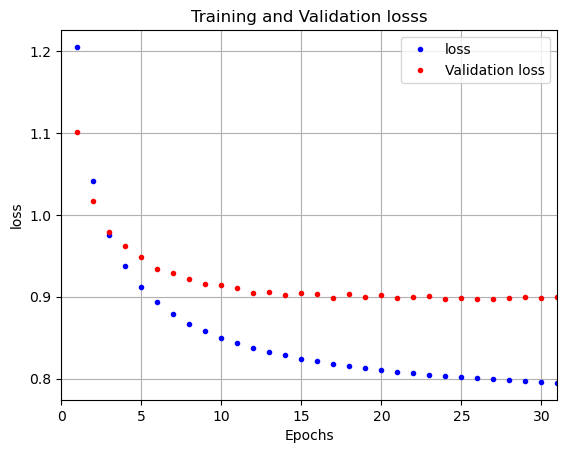

In [26]:
plot_training_history(baseline_history, monitor='loss')

 ## Scaling up: developing a model that overfits

In [27]:

overfit = Sequential(
    [
        Dense(64, activation='relu', input_shape=(INPUT_DIMENSION,)),
        Dense(OUTPUT_CLASSES, activation='softmax')
    ]
)

overfit_initial_weights = overfit.get_weights()
overfit._name = 'overfit'

overfit.summary()

Model: "overfit"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 64)                160064    
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
Total params: 160,324
Trainable params: 160,324
Non-trainable params: 0
_________________________________________________________________


In [28]:
learning_rate = 0.0025

overfit.compile(optimizer=RMSprop(learning_rate=learning_rate), 
                loss=LOSS_FUNC, metrics=METRICS)

overfit.set_weights(overfit_initial_weights)

In [29]:
EPOCHS = 100
batch_size=512

overfit.set_weights(overfit_initial_weights)

overfit_history = overfit.fit(X_train, y_train,
                              class_weight=CLASS_WEIGHT,
                              batch_size=batch_size, epochs=EPOCHS, 
                              validation_data=(X_val, y_val),
                              callbacks=[],
                              verbose=0)

2023-03-08 06:53:40.326486: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 591960000 exceeds 10% of free system memory.


In [30]:
overfit_scores = overfit.evaluate(X_val, y_val, verbose=0)[1:]

print('Accuracy (Validation): {:.2f} (Naive Baseline = {:.2f})'.format(overfit_scores[0], naive_baseline))
print('Precision (Validation): {:.2f}'.format(overfit_scores[1]))
print('Recall (Validation): {:.2f}'.format(overfit_scores[2]))
print('AUC (Validation): {:.2f}'.format(overfit_scores[3]))

Accuracy (Validation): 0.84 (Naive Baseline = 0.30)
Precision (Validation): 0.87
Recall (Validation): 0.83
AUC (Validation): 0.96


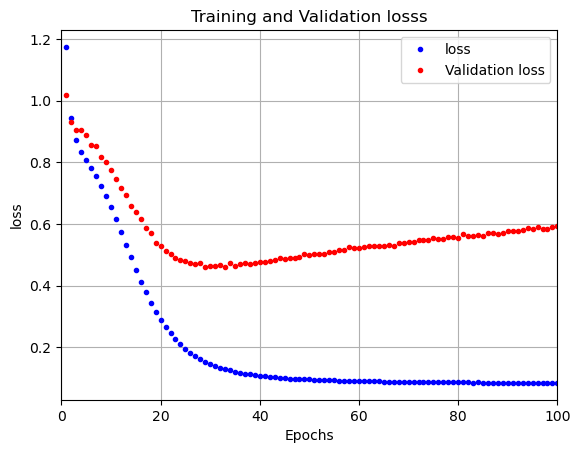

In [31]:
plot_training_history(overfit_history, monitor='loss')

 ## Regularizing your model and tuning your hyperparameters

In [32]:
# over-sized model - neural network architecture that can overfit the data
deep = Sequential(
    [
        Dense(64, activation='relu', input_shape=(INPUT_DIMENSION,)),
        Dropout(0.5),
        Dense(OUTPUT_CLASSES, activation='softmax')
    ]
)

deep_initial_weights = deep.get_weights()
deep._name = 'deep'

deep.summary()

Model: "deep"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                160064    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 4)                 260       
                                                                 
Total params: 160,324
Trainable params: 160,324
Non-trainable params: 0
_________________________________________________________________


In [33]:
wider = Sequential(
    [
        Dense(128, activation='relu', input_shape=(INPUT_DIMENSION,)),
        Dropout(0.5),
        Dense(OUTPUT_CLASSES, activation='softmax')
    ]
)

wider_initial_weights = wider.get_weights()
wider._name = 'wider'

wider.summary()

Model: "wider"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               320128    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 4)                 516       
                                                                 
Total params: 320,644
Trainable params: 320,644
Non-trainable params: 0
_________________________________________________________________


In [34]:
deeper = Sequential(
    [
        Dense(64, activation='relu', input_shape=(INPUT_DIMENSION,)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(OUTPUT_CLASSES, activation='softmax')
    ]
)

deeper_initial_weights = deeper.get_weights()
deeper._name = 'deeper'

deeper.summary()

Model: "deeper"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 64)                160064    
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 4)                 260       
                                                                 
Total params: 164,484
Trainable params: 164,484
Non-trainable params: 0
_________________________________________________________________


In [35]:
def cross_validation(X, y,
                     class_weight,
                     params, kfolds, epochs,
                     callbacks, seed=0) :
    evaluations = []
    for train, validate in kfolds.split(X, y.argmax(axis=1)) :
        model = clone_model(params['model'])
        
        for layer in model.layers :
            if type(layer) == keras.layers.regularization.dropout.Dropout :
                layer.rate = params['dropout']
        
        model.compile(optimizer=RMSprop(learning_rate=params['learning_rate']), 
                      loss=LOSS_FUNC, metrics=METRICS)
        
        history = model.fit(X[train,:], y[train,:],
                            class_weight=class_weight,
                            batch_size=params['batch_size'], epochs=epochs, 
                            validation_data=(X[validate,:], y[validate,:]),
                            callbacks=callbacks,
                            verbose=0)
        
        evaluation = model.evaluate(X_val, y_val, verbose=0)[1:]
        evaluations.append( evaluation )
        
    return np.mean(evaluations, axis=0)

In [36]:
def grid_search_cv(X, y,
                   class_weight,
                   search_space, cv,
                   epochs, callbacks=[], seed=0) :
    
    keys, values = zip(*search_space.items())
    
    kfolds = StratifiedKFold(n_splits=cv, shuffle=True, random_state=seed)
    
    stats = {}
    for params in [dict(zip(keys, v)) for v in itertools.product(*values)] :
        
        scores = cross_validation(X, y, class_weight,
                                  params, kfolds, epochs,
                                  callbacks, seed)
        
        params['model'] = params['model']._name
        
        stats[str(params)] = scores
    
    return stats

In [38]:
# our search space
params = {
    'model': [deep, wider, deeper],
    'dropout': [0.25, 0.5],
    'learning_rate': [0.0025, 0.005],
    'batch_size': [512]
}

EPOCHS = 500
KFOLDS = 5

In [39]:
stats = grid_search_cv(X_train, y_train,
                       class_weight=CLASS_WEIGHT,
                       search_space=params, cv=KFOLDS, epochs=EPOCHS, 
                       callbacks=[EARLY_STOP], seed=SEED)

2023-03-08 06:55:18.016795: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 473560000 exceeds 10% of free system memory.
2023-03-08 06:55:55.727441: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 473570000 exceeds 10% of free system memory.
2023-03-08 06:56:44.943183: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 473570000 exceeds 10% of free system memory.


In [40]:
def dict_to_dataframe(stats) :
    entries = []
    for key, value in stats.items() :
        entry = eval(key)
        
        metrics = ['accuracy', 'precision', 'recall', 'auc']
        for metric, score in zip(metrics, value) :
            entry[metric] = score

        entries.append(entry)

    return pd.DataFrame(entries)

In [41]:
kfold_stats = dict_to_dataframe(stats)

kfold_stats.sort_values(by=['auc'], ascending=False).head(10)

,model,dropout,learning_rate,batch_size,accuracy,precision,recall,auc
5,wider,0.25,0.0050,512,0.843351,0.879721,0.823297,0.966267
4,wider,0.25,0.0025,512,0.839541,0.876757,0.819676,0.964805
7,wider,0.50,0.0050,512,0.836297,0.876725,0.809216,0.962752
6,wider,0.50,0.0025,512,0.832865,0.876509,0.805919,0.961006
1,deep,0.25,0.0050,512,0.817622,0.860134,0.790432,0.954846
0,deep,0.25,0.0025,512,0.818703,0.858386,0.792784,0.954079
9,deeper,0.25,0.0050,512,0.812108,0.855165,0.784324,0.951883
8,deeper,0.25,0.0025,512,0.809595,0.852066,0.781730,0.951411
3,deep,0.50,0.0050,512,0.798838,0.853938,0.753892,0.945248
2,deep,0.50,0.0025,512,0.793622,0.847097,0.749405,0.943247


In [37]:
# the best parameters by AUC are:
# model = wider
# dropout = 0.25
# learning_rate = 0.005
# batch_size = 512

In [42]:
# optimal parameters are taken out from our k-fold grid-search stats
best_params = {
    'model': wider,
    'dropout': 0.25,
    'learning_rate': 0.005,
    'batch_size': 512
}

best_model = clone_model(wider)
best_model.layers[1] = best_params['dropout'] # dropout layer
    
best_model.compile(optimizer=RMSprop(learning_rate=best_params['learning_rate']), 
                   loss=LOSS_FUNC, metrics=METRICS)
        
history = best_model.fit(X_train, y_train,
                         class_weight=CLASS_WEIGHT,
                         batch_size=best_params['batch_size'], epochs=EPOCHS, 
                         validation_data=(X_val, y_val),
                         callbacks=[EARLY_STOP],
                         verbose=0)

In [43]:
validation_scores = best_model.evaluate(X_val, y_val, verbose=0)[1:]

print('Accuracy (Validation): {:.2f} (Naive Baseline = {:.2f})'.format(validation_scores[0], naive_baseline))
print('Precision (Validation): {:.2f}'.format(validation_scores[1]))
print('Recall (Validation): {:.2f}'.format(validation_scores[2]))
print('AUC (Validation): {:.2f}'.format(validation_scores[3]))

Accuracy (Validation): 0.86 (Naive Baseline = 0.30)
Precision (Validation): 0.90
Recall (Validation): 0.83
AUC (Validation): 0.97


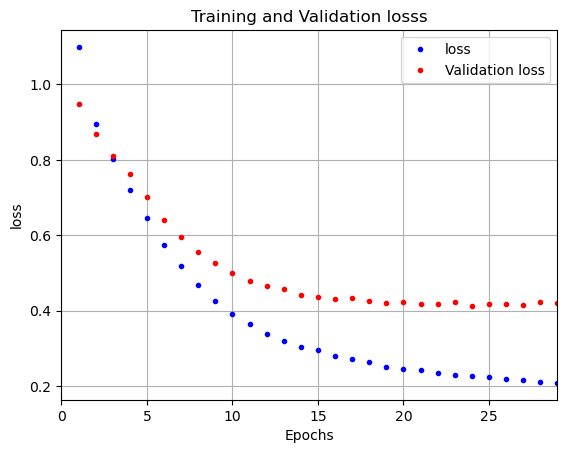

In [44]:
plot_training_history(history, monitor='loss')

In [45]:
test_scores = best_model.evaluate(X_test, y_test, verbose=0)[1:]

print('Accuracy (Validation): {:.2f} (Naive Baseline = {:.2f})'.format(test_scores[0], naive_baseline))
print('Precision (Validation): {:.2f}'.format(test_scores[1]))
print('Recall (Validation): {:.2f}'.format(test_scores[2]))
print('AUC (Validation): {:.2f}'.format(test_scores[3]))

Accuracy (Validation): 0.85 (Naive Baseline = 0.30)
Precision (Validation): 0.90
Recall (Validation): 0.83
AUC (Validation): 0.97
